In [13]:
import warnings

from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()
warnings.filterwarnings('ignore')

import pandas as pd
from nltk.tokenize.casual import casual_tokenize

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    silhouette_score,
)
from sklearn.preprocessing import LabelEncoder


NGRAM_RANGE = (1,1)
N_SAMPLES = 40000
DATASET_PATH = "../data/stemming_post_texts.csv"

In [14]:
corpus_df = pd.read_csv(DATASET_PATH)
corpus_df.head()

,text,sentiment
0,украин эт част рус искусствен отделен котор ру...,negative
1,говор относительн небольш коррупц образован ст...,negative
2,сво поляк сдела русск понятн литовск поляк так...,neutral
3,фильм зрител люб диковин соседк пят месяц узна...,neutral
4,государств плат посмотр денежн поток пенсион ф...,negative


In [15]:
if N_SAMPLES:
    corpus_df = corpus_df.sample(N_SAMPLES)
train_corpus_df = corpus_df.dropna(subset=["text"]).sample(frac=1).reset_index(drop=True)
text_documents_list = train_corpus_df.text.to_list()

In [16]:
label_encoder = LabelEncoder()

In [17]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=casual_tokenize, ngram_range=NGRAM_RANGE, max_features=1000)

In [18]:
%%time
tf_idf_vectorizer.fit(text_documents_list)

CPU times: total: 6.23 s
Wall time: 6.24 s


TfidfVectorizer(max_features=1000,
                tokenizer=<function casual_tokenize at 0x000001D36E4F4CA0>)

In [19]:
%%time
X = tf_idf_vectorizer.transform(train_corpus_df["text"])
y = label_encoder.fit_transform(train_corpus_df["sentiment"])

CPU times: total: 5.92 s
Wall time: 5.97 s


In [20]:
def clustering_report(data, labels, clusters) -> str:
    result = f"ARI: {adjusted_rand_score(labels, clusters)}\n" \
             f"AMI: {adjusted_mutual_info_score(labels, clusters)}\n" \
             f"Homogeneity: {homogeneity_score(labels, clusters)}\n" \
             f"Completeness: {completeness_score(labels, clusters)}\n" \
             f"V-measure: {v_measure_score(labels, clusters)}\n" \
             f"Silhouette: {silhouette_score(data, clusters)}"
    return result

In [21]:
evaluations = []
for n_cluster in range(2, 141, 10):
    print("="*10, f" K-means with {n_cluster} clusters ", "="*10)
    result = {"clusters": n_cluster}
    k_means_model = KMeans(n_clusters=n_cluster)
    k_means_model.fit(X)
    result["silhouette_score"] = silhouette_score(X, k_means_model.labels_)
    evaluations.append(result)
    print(clustering_report(X, y, k_means_model.labels_))
    print("="*40)

==========  K-means with 2 clusters  ==========
ARI: -0.022758470751570645
AMI: 0.030658251245385116
Homogeneity: 0.023841760950679157
Completeness: 0.04306864779320971
V-measure: 0.030692755415232312
Silhouette: 0.022898281940452892
==========  K-means with 12 clusters  ==========
ARI: -0.025173828075731743
AMI: 0.041987274823754056
Homogeneity: 0.05759218514139013
Completeness: 0.03330140913771758
V-measure: 0.04220101396011028
Silhouette: 0.036530729002088716
==========  K-means with 22 clusters  ==========
ARI: 0.046189709604146596
AMI: 0.07912967750085043
Homogeneity: 0.12761213561042692
Completeness: 0.05769511990425903
V-measure: 0.0794636717794209
Silhouette: 0.04321017479761457
==========  K-means with 32 clusters  ==========
ARI: 0.03921064875703462
AMI: 0.08526994076704082
Homogeneity: 0.15251506877858795
Completeness: 0.05960390421703733
V-measure: 0.08571127252554914
Silhouette: 0.04532980285231323
==========  K-means with 42 clusters  ==========
ARI: 0.03112571154432301
A

In [22]:
evaluations_df = pd.DataFrame(data=evaluations)

<AxesSubplot: xlabel='clusters'>

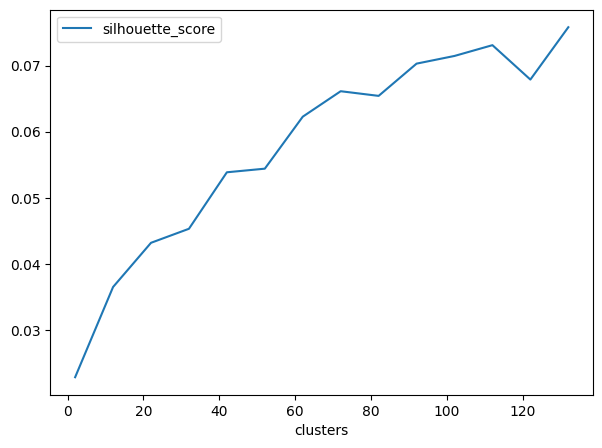

In [23]:
evaluations_df.plot(x="clusters", y="silhouette_score", figsize=(7, 5))